Import necessary modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import matplotlib.pyplot as plt
import random
import cv2
import torch.nn as nn
from torchsummary import summary
from tqdm import tqdm
import torch.optim as optim
import numpy as np
from PIL import Image
from torchvision import datasets, transforms, models
import os
from torch.utils.data import Dataset
import pandas as pd

Some necessary settings (GPU)

In [17]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)
print("You are using PyTorch version: %s" % torch.__version__)

# define class names
classes = ('A', 'B', 'C')

# define the path to the dataset
path_dataset = "dataset_beam/"

You are using device: cuda
You are using PyTorch version: 2.6.0+cu124


Data loading and processing

Edge detection function using morphological operations (Dilation and Erosion)

In [4]:
def compute_mean_std(image_dir):
    """
    Compute the mean and standard deviation of images in a directory.
    Args:
        image_dir (str): Root directory containing class subfolders of images
    Returns:
        mean (tuple): Mean of R, G, B channels
        std (tuple): Standard deviation of R, G, B channels
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to a consistent size
        transforms.ToTensor()           # Convert to [0, 1] and shape (C, H, W)
    ])

    image_paths = []
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    print(f"Found {len(image_paths)} images.")

    channel_sum = np.zeros(3)
    channel_squared_sum = np.zeros(3)
    num_pixels = 0

    for path in tqdm(image_paths, desc="Computing mean & std"):
        image = Image.open(path).convert("RGB")
        image_tensor = transform(image)
        np_image = image_tensor.numpy()

        channel_sum += np_image.sum(axis=(1, 2))
        channel_squared_sum += (np_image ** 2).sum(axis=(1, 2))
        num_pixels += np_image.shape[1] * np_image.shape[2]

    mean = channel_sum / num_pixels
    std = np.sqrt(channel_squared_sum / num_pixels - mean ** 2)

    return tuple(mean), tuple(std)

In [5]:
class QuadraExpandedDataset(Dataset):
    def __init__(self, traindataset, transform1, transform2, transform3):
        self.subset = traindataset
        self.indices = traindataset.indices  # Indices of Subset
        self.base_dataset = traindataset.dataset  # Original ImageFolder
        self.samples = self.base_dataset.samples
        self.loader = self.base_dataset.loader

        self.transform1 = transform1
        self.transform2 = transform2
        self.transform3 = transform3

        self.total_len = len(self.indices) * 3  # Each image will be used 4 times

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        base_idx = idx // 3              # which original image
        aug_idx = idx % 3                 # which augmentation to apply
        true_idx = self.indices[base_idx] # actual index in ImageFolder

        path, label = self.samples[true_idx]
        image = self.loader(path)

        if aug_idx == 0:
            image = self.transform1(image)
        elif aug_idx == 1:
            image = self.transform2(image)
        else:
            image = self.transform3(image)

        return image, label


In [6]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
import os

class OvRDataset(Dataset):
    def __init__(self, root, target_class_idx, transform=None):
        """
        root: path to crack folder
        target_class_idx: integer, the class index we are currently training (0-9)
        """
        self.base_dataset = datasets.ImageFolder(root=root, transform=transform)
        self.target_class_idx = target_class_idx

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        image, label = self.base_dataset[index]

        # One-vs-Rest relabeling:
        binary_label = 1.0 if label == self.target_class_idx else 0.0

        return image, binary_label

In [7]:
def load_dataset(dataset_path):

    # print the size of an image
    # img_path = '/Users/wengtzucheng/Documents/Documents - Weng’s MacBook Pro/碩班/深度學習/Competition/dataset_beam/beam_damage/Class A/007_yang_jpg.rf.e0f01c59605ebc5502e8020751cd684a.jpg'
    # img = cv2.imread(img_path)
    # height, width, channels = img.shape
    # print(f"Image size: {width}x{height}, Channels: {channels}")


    # Calculate mean and standard of images
    mean, std = compute_mean_std(dataset_path)
    # Define a transforms
    transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])


    transform2 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomRotation(15),
      transforms.ColorJitter(brightness=0.2, contrast=0.2),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

    transform3 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

    transform4 = transforms.Compose([
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
      transforms.RandomGrayscale(p=0.2),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
    ])

    # Load full dataset
    full_dataset = datasets.ImageFolder(root = dataset_path, transform=transform)

    # split full dataset into validation and train dataset
    dataset_size = len(full_dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

    train_dataset = QuadraExpandedDataset(train_subset, transform2, transform3, transform4)


    # Create dataLoaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    validation_loader = DataLoader(val_subset, batch_size=64, shuffle=True)

    # Check class names and indices
    print(full_dataset.classes)  # ['ClassA', 'ClassB', 'ClassC']
    print(full_dataset.class_to_idx)  # {'ClassA': 0, 'ClassB': 1, 'ClassC': 2}

    return train_loader, validation_loader, full_dataset

# Load dataset
damage_dataset_path = '/content/drive/MyDrive/dataset_beam/beam_damage'
damage_train_loader, damage_validation_loader, damage_full_dataset = load_dataset(damage_dataset_path)







Found 389 images.


Computing mean & std: 100%|██████████| 389/389 [03:14<00:00,  2.00it/s]

['Class A', 'Class B', 'Class C']
{'Class A': 0, 'Class B': 1, 'Class C': 2}


In [8]:
# Load ImageFolder once to get class_to_idx mapping
crack_dataset_path = '/content/drive/MyDrive/classification/crack'
base_crack_dataset = datasets.ImageFolder(root=crack_dataset_path)
crack_class_to_idx = base_crack_dataset.class_to_idx
crack_class_names = base_crack_dataset.classes

print("Crack classes:", crack_class_names)
print("Crack class_to_idx:", crack_class_to_idx)


# Transforms
mean, std = compute_mean_std(crack_dataset_path)
crack_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Or 256x256 depending on your model
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

batch_size = 64
num_classes = len(crack_class_names)  # Should be 10

train_loaders = []
val_loaders = []

for class_idx in range(num_classes):
    print(f"\nPreparing loaders for class {class_idx}: {crack_class_names[class_idx]}")

    # Create OvRDataset for this class
    ovr_dataset = OvRDataset(root=crack_dataset_path, target_class_idx=class_idx, transform=crack_transforms)

    # Split into train/val
    train_size = int(0.8 * len(ovr_dataset))
    val_size = len(ovr_dataset) - train_size
    train_dataset, val_dataset = random_split(ovr_dataset, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Append to lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

Crack classes: ['0_ExposedRebar', '10_SmallCracks', '1_NoSignificantDamage', '3_XAndV-shapedCracks', '4_ContinuousDiagonalCracks', '5_DiscontinuousDiagonalCracks', '6_ContinuousVerticalCracks', '7_DiscontinuousVerticalCracks', '8_ContinuosHorizontalCracks', '9_DiscontinuousHorizontalCracks']
Crack class_to_idx: {'0_ExposedRebar': 0, '10_SmallCracks': 1, '1_NoSignificantDamage': 2, '3_XAndV-shapedCracks': 3, '4_ContinuousDiagonalCracks': 4, '5_DiscontinuousDiagonalCracks': 5, '6_ContinuousVerticalCracks': 6, '7_DiscontinuousVerticalCracks': 7, '8_ContinuosHorizontalCracks': 8, '9_DiscontinuousHorizontalCracks': 9}
Found 1616 images.


Computing mean & std: 100%|██████████| 1616/1616 [15:37<00:00,  1.72it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Preparing loaders for class 0: 0_ExposedRebar

Preparing loaders for class 1: 10_SmallCracks

Preparing loaders for class 2: 1_NoSignificantDamage

Preparing loaders for class 3: 3_XAndV-shapedCracks

Preparing loaders for class 4: 4_ContinuousDiagonalCracks

Preparing loaders for class 5: 5_DiscontinuousDiagonalCracks

Preparing loaders for class 6: 6_ContinuousVerticalCracks

Preparing loaders for class 7: 7_DiscontinuousVerticalCracks

Preparing loaders for class 8: 8_ContinuosHorizontalCracks

Preparing loaders for class 9: 9_DiscontinuousHorizontalCracks


Mapping

In [9]:
damage_class_names = ['Class A', 'Class B', 'Class C']
damage_class_to_idx = {'Class A': 0, 'Class B': 1, 'Class C': 2}

# Mapping ImageFolder index → 18/19/20
damage_label_mapping = {
    damage_class_to_idx['Class A']: 18,
    damage_class_to_idx['Class B']: 19,
    damage_class_to_idx['Class C']: 20
}

crack_class_names = [
    '0_ExposedRebar',
    '10_SmallCracks',
    '1_NoSignificantDamage',
    '3_XAndV-shapedCracks',
    '4_ContinuousDiagonalCracks',
    '5_DiscontinuousDiagonalCracks',
    '6_ContinuousVerticalCracks',
    '7_DiscontinuousVerticalCracks',
    '8_ContinuosHorizontalCracks',
    '9_DiscontinuousHorizontalCracks'
]

crack_class_to_idx = {
    '0_ExposedRebar': 0,
    '10_SmallCracks': 1,
    '1_NoSignificantDamage': 2,
    '3_XAndV-shapedCracks': 3,
    '4_ContinuousDiagonalCracks': 4,
    '5_DiscontinuousDiagonalCracks': 5,
    '6_ContinuousVerticalCracks': 6,
    '7_DiscontinuousVerticalCracks': 7,
    '8_ContinuosHorizontalCracks': 8,
    '9_DiscontinuousHorizontalCracks': 9
}

# Build mapping: ImageFolder index → index in class list
crack_label_mapping = {
    crack_class_to_idx['0_ExposedRebar']: 0,
    crack_class_to_idx['10_SmallCracks']: 10,
    crack_class_to_idx['1_NoSignificantDamage']: 1,
    crack_class_to_idx['3_XAndV-shapedCracks']: 3,
    crack_class_to_idx['4_ContinuousDiagonalCracks']: 4,
    crack_class_to_idx['5_DiscontinuousDiagonalCracks']: 5,
    crack_class_to_idx['6_ContinuousVerticalCracks']: 6,
    crack_class_to_idx['7_DiscontinuousVerticalCracks']: 7,
    crack_class_to_idx['8_ContinuosHorizontalCracks']: 8,
    crack_class_to_idx['9_DiscontinuousHorizontalCracks']: 9
}

print("Damage label mapping:", damage_label_mapping)
print("Crack label mapping:", crack_label_mapping)

Damage label mapping: {0: 18, 1: 19, 2: 20}
Crack label mapping: {0: 0, 1: 10, 2: 1, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [13]:
# Example
for images, labels in damage_train_loader:
    print(images.shape, labels)
    break

# Example: print every batch in train_loaders[1]

for batch_idx, (images, labels) in enumerate(train_loaders[1]):
    print(f"Batch {batch_idx}:")
    print("  images.shape:", images.shape)  # e.g., (batch_size, 3, 224, 224)
    print("  labels:", labels)              # Tensor of size (batch_size,) with 1.0 or 0.0
    print("-" * 40)

  # Count total number of 1's in train_loader[1]



torch.Size([64, 3, 224, 224]) tensor([2, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0, 1, 0, 1, 1, 1, 1, 1, 2, 2, 0, 1, 0, 0,
        1, 2, 0, 0, 1, 2, 1, 0, 0, 0, 2, 2, 1, 0, 1, 2, 1, 2, 0, 0, 2, 2, 2, 2,
        1, 1, 0, 2, 2, 2, 1, 2, 0, 2, 0, 1, 1, 1, 1, 2])
Batch 0:
  images.shape: torch.Size([64, 3, 224, 224])
  labels: tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
----------------------------------------
Batch 1:
  images.shape: torch.Size([64, 3, 224, 224])
  labels: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 

In [17]:
total_ones = 0
total_samples = 0
for images, labels in train_loaders[8]:
    # Count number of 1.0 labels in this batch
    num_ones = (labels == 1.0).sum().item()

    total_ones += num_ones
    total_samples += labels.size(0)

print(f"Total samples in train_loader[1]: {total_samples}")
print(f"Total number of 1's (positives) in train_loader[1]: {total_ones}")
print(f"Percentage of positives: {100 * total_ones / total_samples:.2f}%")

Total samples in train_loader[1]: 1292
Total number of 1's (positives) in train_loader[1]: 235
Percentage of positives: 18.19%


Model definition

In [19]:
# === Network 1 → Damage level classification ===
model_damage = models.convnext_tiny(pretrained=True)
num_damage_classes = 3  # You have 3 classes

model_damage.classifier[2] = nn.Linear(model_damage.classifier[2].in_features, num_damage_classes)  # 3 classes
model_damage = model_damage.to(device)

# Print summary for sanity check
print("=== Damage Level Classifier ===")
summary(model_damage, (3, 224, 224))

# === Network 2 → Crack multi-label classification ===
model_crack = models.convnext_tiny(pretrained=True)
num_crack_classes = 10  # You have 0-10 → 11 classes total

model_crack.classifier[2] = nn.Linear(model_crack.classifier[2].in_features, num_crack_classes)
# Note: no need to add sigmoid here → use BCEWithLogitsLoss → sigmoid is applied inside loss
model_crack = model_crack.to(device)

# Print summary
print("=== Crack Multi-label Classifier ===")
summary(model_crack, (3, 224, 224))


num_classes = 10
models_crack = []
optimizers = []

for i in range(num_classes):
    model = models.convnext_tiny(pretrained=True)
    model.classifier[2] = nn.Linear(model.classifier[2].in_features, 1)  # binary output
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    models_crack.append(model)
    optimizers.append(optimizer)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=== Damage Level Classifier ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
            Conv2d-3           [-1, 96, 56, 56]           4,800
           Permute-4           [-1, 56, 56, 96]               0
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
            Linear-8           [-1, 56, 56, 96]          36,960
           Permute-9           [-1, 96, 56, 56]               0
  StochasticDepth-10           [-1, 96, 56, 56]               0
          CNBlock-11           [-1, 96, 56, 56]               0
           Conv2d-12           [-1, 96, 56, 56]           4,800
          Permute-13           [-1, 56, 56, 96]               0
       

Model training

In [15]:
def train(model, trainloader, valloader, optimizer, device,
          epochs=10, mode='single', patience=5):

    # Select loss based on mode
    if mode == 'single':
        criterion = nn.CrossEntropyLoss()
    elif mode == 'multi':
        criterion = nn.BCEWithLogitsLoss()
    else:
        raise ValueError(f"Unsupported mode: {mode}")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    # Lists for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)
        for i, data in loop:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Multi-label needs labels as float
            if mode == 'multi':
                labels = labels.float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accuracy calculation
            if mode == 'single':
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            elif mode == 'multi':
                # Multi-label accuracy: threshold 0.5 → compare with ground truth
                preds = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.numel()
                correct += (preds == labels).sum().item()

            running_loss += loss.item()

            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

        # Training stats
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                if mode == 'multi':
                    labels = labels.float()

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                if mode == 'single':
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                elif mode == 'multi':
                    preds = (torch.sigmoid(outputs) > 0.5).float()
                    val_total += labels.numel()
                    val_correct += (preds == labels).sum().item()

        # Validation stats
        epoch_val_loss = val_running_loss / len(valloader)
        scheduler.step(epoch_val_loss)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            print(f"  → New best val loss: {best_val_loss:.4f}. Saving model checkpoint.")
            torch.save(model.state_dict(), f'best_model_{mode}.pth')
        else:
            patience_counter += 1
            print(f"No improvement. Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    print('Finished Training')

    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [20]:
# === Stage 1: Freeze backbone, train classifier ===

# Freeze backbone
for param in model_damage.features.parameters():
    param.requires_grad = False

# Optimizer — only optimize classifier head
optimizer = optim.Adam(model_damage.classifier.parameters(), lr=1e-3, weight_decay=1e-4)

# Train model (only head)
train(model_damage, damage_train_loader, damage_validation_loader, optimizer, device, epochs=50, mode='single')

# === Stage 2: Unfreeze backbone, fine-tune full model ===

# Unfreeze backbone
for param in model_damage.features.parameters():
    param.requires_grad = True

# Optimizer — now optimize ALL parameters (backbone + classifier)
optimizer = optim.Adam(model_damage.parameters(), lr=1e-4, weight_decay=1e-4)  # smaller LR for fine-tuning

# Train model again (fine-tune full model)
train(model_damage, damage_train_loader, damage_validation_loader, optimizer, device, epochs=50, mode='single')


Epoch [1/50]: 100%|██████████| 15/15 [00:11<00:00,  1.28it/s, accuracy=57.6, loss=0.932]


Epoch 1/50
Train Loss: 0.9318, Train Acc: 57.56%
Val Loss: 0.8455, Val Acc: 64.10%
------------------------------------------------------------
  → New best val loss: 0.8455. Saving model checkpoint.


Epoch [2/50]: 100%|██████████| 15/15 [00:11<00:00,  1.27it/s, accuracy=79.5, loss=0.617]


Epoch 2/50
Train Loss: 0.6171, Train Acc: 79.53%
Val Loss: 0.7515, Val Acc: 64.10%
------------------------------------------------------------
  → New best val loss: 0.7515. Saving model checkpoint.


Epoch [3/50]: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s, accuracy=81.7, loss=0.514]


Epoch 3/50
Train Loss: 0.5144, Train Acc: 81.67%
Val Loss: 0.6185, Val Acc: 71.79%
------------------------------------------------------------
  → New best val loss: 0.6185. Saving model checkpoint.


Epoch [4/50]: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s, accuracy=84.8, loss=0.444]


Epoch 4/50
Train Loss: 0.4437, Train Acc: 84.78%
Val Loss: 0.6820, Val Acc: 70.51%
------------------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [5/50]: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s, accuracy=86.2, loss=0.395]


Epoch 5/50
Train Loss: 0.3947, Train Acc: 86.17%
Val Loss: 0.6265, Val Acc: 71.79%
------------------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [6/50]: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s, accuracy=88.4, loss=0.361]


Epoch 6/50
Train Loss: 0.3608, Train Acc: 88.42%
Val Loss: 0.6682, Val Acc: 74.36%
------------------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [7/50]: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s, accuracy=88.1, loss=0.349]


Epoch 7/50
Train Loss: 0.3486, Train Acc: 88.10%
Val Loss: 0.7857, Val Acc: 74.36%
------------------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [8/50]: 100%|██████████| 15/15 [00:11<00:00,  1.30it/s, accuracy=89.1, loss=0.334]


Epoch 8/50
Train Loss: 0.3342, Train Acc: 89.07%
Val Loss: 0.5971, Val Acc: 76.92%
------------------------------------------------------------
  → New best val loss: 0.5971. Saving model checkpoint.


Epoch [9/50]: 100%|██████████| 15/15 [00:11<00:00,  1.28it/s, accuracy=90.2, loss=0.319]


Epoch 9/50
Train Loss: 0.3187, Train Acc: 90.25%
Val Loss: 0.5384, Val Acc: 76.92%
------------------------------------------------------------
  → New best val loss: 0.5384. Saving model checkpoint.


Epoch [10/50]: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s, accuracy=90.1, loss=0.322]


Epoch 10/50
Train Loss: 0.3221, Train Acc: 90.14%
Val Loss: 0.5255, Val Acc: 78.21%
------------------------------------------------------------
  → New best val loss: 0.5255. Saving model checkpoint.


Epoch [11/50]: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s, accuracy=90.2, loss=0.304]


Epoch 11/50
Train Loss: 0.3043, Train Acc: 90.25%
Val Loss: 0.4493, Val Acc: 78.21%
------------------------------------------------------------
  → New best val loss: 0.4493. Saving model checkpoint.


Epoch [12/50]: 100%|██████████| 15/15 [00:11<00:00,  1.27it/s, accuracy=90.4, loss=0.309]


Epoch 12/50
Train Loss: 0.3089, Train Acc: 90.35%
Val Loss: 0.7102, Val Acc: 78.21%
------------------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [13/50]: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s, accuracy=90.6, loss=0.287]


Epoch 13/50
Train Loss: 0.2866, Train Acc: 90.57%
Val Loss: 0.6800, Val Acc: 78.21%
------------------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [14/50]: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s, accuracy=90.5, loss=0.296]


Epoch 14/50
Train Loss: 0.2958, Train Acc: 90.46%
Val Loss: 0.6905, Val Acc: 79.49%
------------------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [15/50]: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s, accuracy=92.1, loss=0.264]


Epoch 15/50
Train Loss: 0.2637, Train Acc: 92.07%
Val Loss: 0.6526, Val Acc: 78.21%
------------------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [16/50]: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s, accuracy=91.9, loss=0.269]


Epoch 16/50
Train Loss: 0.2688, Train Acc: 91.85%
Val Loss: 0.5933, Val Acc: 76.92%
------------------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Finished Training


Epoch [1/50]: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it, accuracy=92.6, loss=0.225]


Epoch 1/50
Train Loss: 0.2246, Train Acc: 92.60%
Val Loss: 0.5760, Val Acc: 87.18%
------------------------------------------------------------
  → New best val loss: 0.5760. Saving model checkpoint.


Epoch [2/50]: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it, accuracy=98.5, loss=0.0656]


Epoch 2/50
Train Loss: 0.0656, Train Acc: 98.50%
Val Loss: 0.3082, Val Acc: 87.18%
------------------------------------------------------------
  → New best val loss: 0.3082. Saving model checkpoint.


Epoch [3/50]: 100%|██████████| 15/15 [00:22<00:00,  1.49s/it, accuracy=99.7, loss=0.023]


Epoch 3/50
Train Loss: 0.0230, Train Acc: 99.68%
Val Loss: 0.4558, Val Acc: 88.46%
------------------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [4/50]: 100%|██████████| 15/15 [00:21<00:00,  1.47s/it, accuracy=99.7, loss=0.0123]


Epoch 4/50
Train Loss: 0.0123, Train Acc: 99.68%
Val Loss: 0.4474, Val Acc: 83.33%
------------------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [5/50]: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it, accuracy=99.8, loss=0.00905]


Epoch 5/50
Train Loss: 0.0090, Train Acc: 99.79%
Val Loss: 0.4484, Val Acc: 87.18%
------------------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [6/50]: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it, accuracy=99.9, loss=0.00512]


Epoch 6/50
Train Loss: 0.0051, Train Acc: 99.89%
Val Loss: 0.6464, Val Acc: 88.46%
------------------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [7/50]: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it, accuracy=99.9, loss=0.00627]


Epoch 7/50
Train Loss: 0.0063, Train Acc: 99.89%
Val Loss: 0.5679, Val Acc: 87.18%
------------------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Finished Training


(ConvNeXt(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
       (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
     )
     (1): Sequential(
       (0): CNBlock(
         (block): Sequential(
           (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
           (1): Permute()
           (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
           (3): Linear(in_features=96, out_features=384, bias=True)
           (4): GELU(approximate='none')
           (5): Linear(in_features=384, out_features=96, bias=True)
           (6): Permute()
         )
         (stochastic_depth): StochasticDepth(p=0.0, mode=row)
       )
       (1): CNBlock(
         (block): Sequential(
           (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
           (1): Permute()
           (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          

In [22]:
def train_binary(model, train_loader, val_loader, optimizer, device, epochs=10, patience=5, save_path='best_model.pth'):
    # === Compute pos_weight ===
    total_ones = 0
    total_samples = 0

    for _, labels in train_loader:
        total_ones += (labels == 1.0).sum().item()
        total_samples += labels.size(0)

    num_positives = total_ones
    num_negatives = total_samples - total_ones

    pos_weight_value = num_negatives / num_positives
    print(f"Using pos_weight = {pos_weight_value:.4f} (Positives={num_positives}, Negatives={num_negatives})")

    # === Define loss with pos_weight ===
    pos_weight_tensor = torch.tensor([pos_weight_value], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    # === Rest of training loop ===
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # === Training phase ===
        model.train()
        running_loss = 0.0

        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
        for i, (inputs, labels) in loop:
            inputs = inputs.to(device)
            labels = labels.to(device).float()  # BCEWithLogits → float labels (0 or 1)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)  # shape: (batch_size,)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/(i+1))

        epoch_train_loss = running_loss / len(train_loader)

        # === Validation phase ===
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                outputs = model(inputs).squeeze(1)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                # Accuracy: apply sigmoid, threshold 0.5
                probs = torch.sigmoid(outputs)
                print(preds)
                preds = (probs > 0.5).float()

                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_running_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # === Print summary ===
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print("-" * 50)

        # === Early stopping check ===
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            print(f"→ New best val loss: {best_val_loss:.4f}. Saving model...")
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            print(f"No improvement. Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    print("Training complete.")


In [12]:
for i in range(num_classes):
    print(f"\n=== Training classifier for class {i} ===")

    # You need to build a train/val loader for class i
    # Labels should be 1 if image belongs to class i, else 0
    train_loader = train_loaders[i]  # prepare loader for class i
    val_loader = val_loaders[i]    # prepare loader for class i

    train_binary(models_crack[i], train_loader, val_loader, optimizers[i], device, epochs=20)

    # Save model
    torch.save(models_crack[i].state_dict(), f'ovr_model_class_{i}.pth')


=== Training classifier for class 0 ===
Using pos_weight = 160.5000 (Positives=8, Negatives=1284)


Epoch [1/20]: 100%|██████████| 21/21 [00:20<00:00,  1.01it/s, loss=1.61]


Epoch 1/20
Train Loss: 1.6144
Val Loss: 0.8034, Val Acc: 94.44%
--------------------------------------------------
→ New best val loss: 0.8034. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:20<00:00,  1.03it/s, loss=0.343]


Epoch 2/20
Train Loss: 0.3434
Val Loss: 0.4475, Val Acc: 98.46%
--------------------------------------------------
→ New best val loss: 0.4475. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.05s/it, loss=0.1]


Epoch 3/20
Train Loss: 0.1004
Val Loss: 0.0767, Val Acc: 99.07%
--------------------------------------------------
→ New best val loss: 0.0767. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it, loss=0.0218]


Epoch 4/20
Train Loss: 0.0218
Val Loss: 0.1516, Val Acc: 100.00%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [5/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0123]


Epoch 5/20
Train Loss: 0.0123
Val Loss: 0.2087, Val Acc: 100.00%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [6/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.00886]


Epoch 6/20
Train Loss: 0.0089
Val Loss: 0.3158, Val Acc: 100.00%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [7/20]: 100%|██████████| 21/21 [00:22<00:00,  1.05s/it, loss=0.00746]


Epoch 7/20
Train Loss: 0.0075
Val Loss: 0.3340, Val Acc: 100.00%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [8/20]: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it, loss=0.00846]


Epoch 8/20
Train Loss: 0.0085
Val Loss: 0.2215, Val Acc: 100.00%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 1 ===
Using pos_weight = 13.8506 (Positives=87, Negatives=1205)


Epoch [1/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.87]


Epoch 1/20
Train Loss: 0.8698
Val Loss: 0.4145, Val Acc: 88.89%
--------------------------------------------------
→ New best val loss: 0.4145. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:24<00:00,  1.15s/it, loss=0.3]


Epoch 2/20
Train Loss: 0.2999
Val Loss: 0.2735, Val Acc: 88.89%
--------------------------------------------------
→ New best val loss: 0.2735. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.162]


Epoch 3/20
Train Loss: 0.1623
Val Loss: 0.1740, Val Acc: 97.84%
--------------------------------------------------
→ New best val loss: 0.1740. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0964]


Epoch 4/20
Train Loss: 0.0964
Val Loss: 0.0855, Val Acc: 99.38%
--------------------------------------------------
→ New best val loss: 0.0855. Saving model...


Epoch [5/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0427]


Epoch 5/20
Train Loss: 0.0427
Val Loss: 0.1830, Val Acc: 97.84%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [6/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.0286]


Epoch 6/20
Train Loss: 0.0286
Val Loss: 0.1158, Val Acc: 95.37%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [7/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0699]


Epoch 7/20
Train Loss: 0.0699
Val Loss: 0.1762, Val Acc: 94.14%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [8/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0762]


Epoch 8/20
Train Loss: 0.0762
Val Loss: 0.2301, Val Acc: 98.77%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [9/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0203]


Epoch 9/20
Train Loss: 0.0203
Val Loss: 0.6207, Val Acc: 97.84%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 2 ===
Using pos_weight = 20.5333 (Positives=60, Negatives=1232)


Epoch [1/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.909]


Epoch 1/20
Train Loss: 0.9090
Val Loss: 0.4689, Val Acc: 97.53%
--------------------------------------------------
→ New best val loss: 0.4689. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.473]


Epoch 2/20
Train Loss: 0.4734
Val Loss: 0.2628, Val Acc: 96.91%
--------------------------------------------------
→ New best val loss: 0.2628. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.259]


Epoch 3/20
Train Loss: 0.2590
Val Loss: 0.2543, Val Acc: 91.36%
--------------------------------------------------
→ New best val loss: 0.2543. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.137]


Epoch 4/20
Train Loss: 0.1370
Val Loss: 0.1581, Val Acc: 96.30%
--------------------------------------------------
→ New best val loss: 0.1581. Saving model...


Epoch [5/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0839]


Epoch 5/20
Train Loss: 0.0839
Val Loss: 0.0975, Val Acc: 98.77%
--------------------------------------------------
→ New best val loss: 0.0975. Saving model...


Epoch [6/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0334]


Epoch 6/20
Train Loss: 0.0334
Val Loss: 0.3132, Val Acc: 99.38%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [7/20]: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it, loss=0.0278]


Epoch 7/20
Train Loss: 0.0278
Val Loss: 0.2873, Val Acc: 98.77%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [8/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0349]


Epoch 8/20
Train Loss: 0.0349
Val Loss: 0.2232, Val Acc: 97.84%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [9/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.0298]


Epoch 9/20
Train Loss: 0.0298
Val Loss: 0.3409, Val Acc: 97.84%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [10/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.0162]


Epoch 10/20
Train Loss: 0.0162
Val Loss: 0.3590, Val Acc: 98.15%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 3 ===
Using pos_weight = 8.5000 (Positives=136, Negatives=1156)


Epoch [1/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.917]


Epoch 1/20
Train Loss: 0.9174
Val Loss: 0.4991, Val Acc: 85.80%
--------------------------------------------------
→ New best val loss: 0.4991. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.352]


Epoch 2/20
Train Loss: 0.3523
Val Loss: 0.1694, Val Acc: 98.77%
--------------------------------------------------
→ New best val loss: 0.1694. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.0998]


Epoch 3/20
Train Loss: 0.0998
Val Loss: 0.1585, Val Acc: 95.68%
--------------------------------------------------
→ New best val loss: 0.1585. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.12]


Epoch 4/20
Train Loss: 0.1203
Val Loss: 0.1502, Val Acc: 92.90%
--------------------------------------------------
→ New best val loss: 0.1502. Saving model...


Epoch [5/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0512]


Epoch 5/20
Train Loss: 0.0512
Val Loss: 0.0570, Val Acc: 98.77%
--------------------------------------------------
→ New best val loss: 0.0570. Saving model...


Epoch [6/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.024]


Epoch 6/20
Train Loss: 0.0240
Val Loss: 0.1634, Val Acc: 98.15%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [7/20]: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it, loss=0.0092]


Epoch 7/20
Train Loss: 0.0092
Val Loss: 0.0733, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [8/20]: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it, loss=0.00433]


Epoch 8/20
Train Loss: 0.0043
Val Loss: 0.1357, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [9/20]: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it, loss=0.00367]


Epoch 9/20
Train Loss: 0.0037
Val Loss: 0.0510, Val Acc: 99.07%
--------------------------------------------------
→ New best val loss: 0.0510. Saving model...


Epoch [10/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.00602]


Epoch 10/20
Train Loss: 0.0060
Val Loss: 0.2860, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [11/20]: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it, loss=0.0483]


Epoch 11/20
Train Loss: 0.0483
Val Loss: 0.1580, Val Acc: 94.14%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [12/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0917]


Epoch 12/20
Train Loss: 0.0917
Val Loss: 0.6231, Val Acc: 87.96%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [13/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.0845]


Epoch 13/20
Train Loss: 0.0845
Val Loss: 0.1150, Val Acc: 98.46%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [14/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0435]


Epoch 14/20
Train Loss: 0.0435
Val Loss: 0.2749, Val Acc: 98.46%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 4 ===
Using pos_weight = 2.2060 (Positives=403, Negatives=889)


Epoch [1/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.771]


Epoch 1/20
Train Loss: 0.7706
Val Loss: 0.5111, Val Acc: 81.17%
--------------------------------------------------
→ New best val loss: 0.5111. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.379]


Epoch 2/20
Train Loss: 0.3791
Val Loss: 0.3302, Val Acc: 90.74%
--------------------------------------------------
→ New best val loss: 0.3302. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it, loss=0.161]


Epoch 3/20
Train Loss: 0.1607
Val Loss: 0.2474, Val Acc: 92.59%
--------------------------------------------------
→ New best val loss: 0.2474. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0608]


Epoch 4/20
Train Loss: 0.0608
Val Loss: 0.1839, Val Acc: 95.68%
--------------------------------------------------
→ New best val loss: 0.1839. Saving model...


Epoch [5/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0357]


Epoch 5/20
Train Loss: 0.0357
Val Loss: 0.1781, Val Acc: 95.99%
--------------------------------------------------
→ New best val loss: 0.1781. Saving model...


Epoch [6/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0187]


Epoch 6/20
Train Loss: 0.0187
Val Loss: 0.3104, Val Acc: 92.90%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [7/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.027]


Epoch 7/20
Train Loss: 0.0270
Val Loss: 0.3085, Val Acc: 92.59%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [8/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0485]


Epoch 8/20
Train Loss: 0.0485
Val Loss: 0.4704, Val Acc: 91.36%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [9/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.0723]


Epoch 9/20
Train Loss: 0.0723
Val Loss: 0.2857, Val Acc: 91.36%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [10/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0285]


Epoch 10/20
Train Loss: 0.0285
Val Loss: 0.1412, Val Acc: 95.99%
--------------------------------------------------
→ New best val loss: 0.1412. Saving model...


Epoch [11/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.0172]


Epoch 11/20
Train Loss: 0.0172
Val Loss: 0.1687, Val Acc: 95.99%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [12/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0118]


Epoch 12/20
Train Loss: 0.0118
Val Loss: 0.1408, Val Acc: 96.91%
--------------------------------------------------
→ New best val loss: 0.1408. Saving model...


Epoch [13/20]: 100%|██████████| 21/21 [00:24<00:00,  1.17s/it, loss=0.00498]


Epoch 13/20
Train Loss: 0.0050
Val Loss: 0.2793, Val Acc: 93.83%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [14/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.0312]


Epoch 14/20
Train Loss: 0.0312
Val Loss: 0.1998, Val Acc: 95.37%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [15/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.00997]


Epoch 15/20
Train Loss: 0.0100
Val Loss: 0.2330, Val Acc: 94.75%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [16/20]: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it, loss=0.0127]


Epoch 16/20
Train Loss: 0.0127
Val Loss: 0.1930, Val Acc: 95.06%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [17/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.015]


Epoch 17/20
Train Loss: 0.0150
Val Loss: 0.4174, Val Acc: 92.90%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 5 ===
Using pos_weight = 17.4571 (Positives=70, Negatives=1222)


Epoch [1/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=1.01]


Epoch 1/20
Train Loss: 1.0108
Val Loss: 0.5713, Val Acc: 79.63%
--------------------------------------------------
→ New best val loss: 0.5713. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.39]


Epoch 2/20
Train Loss: 0.3899
Val Loss: 0.1525, Val Acc: 99.07%
--------------------------------------------------
→ New best val loss: 0.1525. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.132]


Epoch 3/20
Train Loss: 0.1324
Val Loss: 0.0670, Val Acc: 99.69%
--------------------------------------------------
→ New best val loss: 0.0670. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0797]


Epoch 4/20
Train Loss: 0.0797
Val Loss: 0.2728, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [5/20]: 100%|██████████| 21/21 [00:24<00:00,  1.15s/it, loss=0.0549]


Epoch 5/20
Train Loss: 0.0549
Val Loss: 0.1798, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [6/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.0317]


Epoch 6/20
Train Loss: 0.0317
Val Loss: 0.2445, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [7/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.019]


Epoch 7/20
Train Loss: 0.0190
Val Loss: 0.2034, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [8/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0434]


Epoch 8/20
Train Loss: 0.0434
Val Loss: 0.0249, Val Acc: 99.07%
--------------------------------------------------
→ New best val loss: 0.0249. Saving model...


Epoch [9/20]: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it, loss=0.0169]


Epoch 9/20
Train Loss: 0.0169
Val Loss: 0.0116, Val Acc: 99.69%
--------------------------------------------------
→ New best val loss: 0.0116. Saving model...


Epoch [10/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0213]


Epoch 10/20
Train Loss: 0.0213
Val Loss: 0.0111, Val Acc: 99.69%
--------------------------------------------------
→ New best val loss: 0.0111. Saving model...


Epoch [11/20]: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it, loss=0.0121]


Epoch 11/20
Train Loss: 0.0121
Val Loss: 0.1717, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [12/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.172]


Epoch 12/20
Train Loss: 0.1717
Val Loss: 0.0454, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [13/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.161]


Epoch 13/20
Train Loss: 0.1607
Val Loss: 0.1097, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [14/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0488]


Epoch 14/20
Train Loss: 0.0488
Val Loss: 0.0162, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [15/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.00991]


Epoch 15/20
Train Loss: 0.0099
Val Loss: 0.1444, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 6 ===
Using pos_weight = 4.4979 (Positives=235, Negatives=1057)


Epoch [1/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.648]


Epoch 1/20
Train Loss: 0.6483
Val Loss: 0.3793, Val Acc: 86.73%
--------------------------------------------------
→ New best val loss: 0.3793. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.269]


Epoch 2/20
Train Loss: 0.2690
Val Loss: 0.3003, Val Acc: 95.68%
--------------------------------------------------
→ New best val loss: 0.3003. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.105]


Epoch 3/20
Train Loss: 0.1049
Val Loss: 0.1186, Val Acc: 99.38%
--------------------------------------------------
→ New best val loss: 0.1186. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0388]


Epoch 4/20
Train Loss: 0.0388
Val Loss: 0.1127, Val Acc: 98.46%
--------------------------------------------------
→ New best val loss: 0.1127. Saving model...


Epoch [5/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0163]


Epoch 5/20
Train Loss: 0.0163
Val Loss: 0.0861, Val Acc: 99.38%
--------------------------------------------------
→ New best val loss: 0.0861. Saving model...


Epoch [6/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0103]


Epoch 6/20
Train Loss: 0.0103
Val Loss: 0.1996, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [7/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.00599]


Epoch 7/20
Train Loss: 0.0060
Val Loss: 0.0460, Val Acc: 99.38%
--------------------------------------------------
→ New best val loss: 0.0460. Saving model...


Epoch [8/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.00508]


Epoch 8/20
Train Loss: 0.0051
Val Loss: 0.1583, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [9/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.00275]


Epoch 9/20
Train Loss: 0.0027
Val Loss: 0.1015, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [10/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.00183]


Epoch 10/20
Train Loss: 0.0018
Val Loss: 0.0695, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [11/20]: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it, loss=0.00174]


Epoch 11/20
Train Loss: 0.0017
Val Loss: 0.0340, Val Acc: 99.69%
--------------------------------------------------
→ New best val loss: 0.0340. Saving model...


Epoch [12/20]: 100%|██████████| 21/21 [00:23<00:00,  1.14s/it, loss=0.00605]


Epoch 12/20
Train Loss: 0.0061
Val Loss: 0.0792, Val Acc: 99.69%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [13/20]: 100%|██████████| 21/21 [00:24<00:00,  1.14s/it, loss=0.0148]


Epoch 13/20
Train Loss: 0.0148
Val Loss: 0.9784, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [14/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0359]


Epoch 14/20
Train Loss: 0.0359
Val Loss: 0.0637, Val Acc: 97.84%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [15/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.0567]


Epoch 15/20
Train Loss: 0.0567
Val Loss: 0.0660, Val Acc: 99.38%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [16/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0147]


Epoch 16/20
Train Loss: 0.0147
Val Loss: 0.0913, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 7 ===
Using pos_weight = 52.8333 (Positives=24, Negatives=1268)


Epoch [1/20]: 100%|██████████| 21/21 [00:22<00:00,  1.05s/it, loss=1.29]


Epoch 1/20
Train Loss: 1.2874
Val Loss: 0.6816, Val Acc: 89.81%
--------------------------------------------------
→ New best val loss: 0.6816. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.473]


Epoch 2/20
Train Loss: 0.4730
Val Loss: 0.3471, Val Acc: 94.75%
--------------------------------------------------
→ New best val loss: 0.3471. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.146]


Epoch 3/20
Train Loss: 0.1459
Val Loss: 0.6103, Val Acc: 97.22%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.0591]


Epoch 4/20
Train Loss: 0.0591
Val Loss: 0.8744, Val Acc: 97.53%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [5/20]: 100%|██████████| 21/21 [00:23<00:00,  1.10s/it, loss=0.0327]


Epoch 5/20
Train Loss: 0.0327
Val Loss: 0.7036, Val Acc: 98.77%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [6/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.0225]


Epoch 6/20
Train Loss: 0.0225
Val Loss: 1.4043, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [7/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0103]


Epoch 7/20
Train Loss: 0.0103
Val Loss: 1.2796, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 8 ===
Using pos_weight = 4.2735 (Positives=245, Negatives=1047)


Epoch [1/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.725]


Epoch 1/20
Train Loss: 0.7252
Val Loss: 0.3610, Val Acc: 94.14%
--------------------------------------------------
→ New best val loss: 0.3610. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.287]


Epoch 2/20
Train Loss: 0.2870
Val Loss: 0.2328, Val Acc: 96.30%
--------------------------------------------------
→ New best val loss: 0.2328. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.125]


Epoch 3/20
Train Loss: 0.1248
Val Loss: 0.1217, Val Acc: 97.53%
--------------------------------------------------
→ New best val loss: 0.1217. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0598]


Epoch 4/20
Train Loss: 0.0598
Val Loss: 0.1455, Val Acc: 98.46%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [5/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.0258]


Epoch 5/20
Train Loss: 0.0258
Val Loss: 0.0843, Val Acc: 98.15%
--------------------------------------------------
→ New best val loss: 0.0843. Saving model...


Epoch [6/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0163]


Epoch 6/20
Train Loss: 0.0163
Val Loss: 0.0984, Val Acc: 98.77%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [7/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.0134]


Epoch 7/20
Train Loss: 0.0134
Val Loss: 0.1912, Val Acc: 98.46%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [8/20]: 100%|██████████| 21/21 [00:22<00:00,  1.09s/it, loss=0.0155]


Epoch 8/20
Train Loss: 0.0155
Val Loss: 0.0885, Val Acc: 97.84%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [9/20]: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it, loss=0.0127]


Epoch 9/20
Train Loss: 0.0127
Val Loss: 0.1121, Val Acc: 97.22%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [10/20]: 100%|██████████| 21/21 [00:23<00:00,  1.13s/it, loss=0.0271]


Epoch 10/20
Train Loss: 0.0271
Val Loss: 0.1409, Val Acc: 98.77%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.

=== Training classifier for class 9 ===
Using pos_weight = 35.9143 (Positives=35, Negatives=1257)


Epoch [1/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=1.27]


Epoch 1/20
Train Loss: 1.2744
Val Loss: 0.5042, Val Acc: 90.12%
--------------------------------------------------
→ New best val loss: 0.5042. Saving model...


Epoch [2/20]: 100%|██████████| 21/21 [00:23<00:00,  1.12s/it, loss=0.477]


Epoch 2/20
Train Loss: 0.4775
Val Loss: 0.2719, Val Acc: 92.28%
--------------------------------------------------
→ New best val loss: 0.2719. Saving model...


Epoch [3/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.195]


Epoch 3/20
Train Loss: 0.1949
Val Loss: 0.1066, Val Acc: 99.07%
--------------------------------------------------
→ New best val loss: 0.1066. Saving model...


Epoch [4/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0535]


Epoch 4/20
Train Loss: 0.0535
Val Loss: 0.2503, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 1/5


Epoch [5/20]: 100%|██████████| 21/21 [00:22<00:00,  1.08s/it, loss=0.0517]


Epoch 5/20
Train Loss: 0.0517
Val Loss: 0.1295, Val Acc: 99.38%
--------------------------------------------------
No improvement. Patience counter: 2/5


Epoch [6/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.0194]


Epoch 6/20
Train Loss: 0.0194
Val Loss: 0.2188, Val Acc: 99.07%
--------------------------------------------------
No improvement. Patience counter: 3/5


Epoch [7/20]: 100%|██████████| 21/21 [00:22<00:00,  1.07s/it, loss=0.00848]


Epoch 7/20
Train Loss: 0.0085
Val Loss: 0.3275, Val Acc: 99.38%
--------------------------------------------------
No improvement. Patience counter: 4/5


Epoch [8/20]: 100%|██████████| 21/21 [00:22<00:00,  1.06s/it, loss=0.00643]


Epoch 8/20
Train Loss: 0.0064
Val Loss: 0.5885, Val Acc: 99.38%
--------------------------------------------------
No improvement. Patience counter: 5/5
Early stopping triggered!
Training complete.


In [13]:
def filter_predicted_criteria(damage_label, predicted_criteria):
    """
    damage_label → 18 / 19 / 20
    predicted_criteria → list of crack class indices
    Returns filtered list of crack class indices that are allowed for this damage level
    """

    # Example rule — adjust according to your needs!
    allowed_criteria = {
        18: [0],  # allowed crack reasons when damage level = 18
        19: [3, 4, 5, 8],     # allowed crack reasons when damage level = 19
        20: [1, 5, 7, 9, 10]  # allowed crack reasons when damage level = 20
    }

    allowed = allowed_criteria.get(damage_label, [])  # default empty if unknown

    # Filter predicted_criteria to only keep allowed ones
    filtered = [cls for cls in predicted_criteria if cls in allowed]

    return filtered


In [21]:
import os
import glob
import csv
import torch
from torchvision import models, transforms
from PIL import Image

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load trained damage model ===
model_damage = models.convnext_tiny(pretrained=False)
model_damage.classifier[2] = torch.nn.Linear(model_damage.classifier[2].in_features, 3)
model_damage.load_state_dict(torch.load('/content/best_model_single.pth'))  # adjust path if needed
model_damage = model_damage.to(device)
model_damage.eval()

# Crack class names → same as during training
crack_class_names = [
    '0_ExposedRebar',
    '10_SmallCracks',
    '1_NoSignificantDamage',
    '3_XAndV-shapedCracks',
    '4_ContinuousDiagonalCracks',
    '5_DiscontinuousDiagonalCracks',
    '6_ContinuousVerticalCracks',
    '7_DiscontinuousVerticalCracks',
    '8_ContinuosHorizontalCracks',
    '9_DiscontinuousHorizontalCracks'
]

num_classes = len(crack_class_names)

# Mapping ImageFolder index → index in class list
crack_label_mapping = {
    0: 0,
    1: 10,
    2: 1,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    8: 8,
    9: 9
}

# === Load trained OvR models ===
ovr_models = []

for i in range(num_classes):
    model = models.convnext_tiny(pretrained=False)
    model.classifier[2] = torch.nn.Linear(model.classifier[2].in_features, 1)
    model.load_state_dict(torch.load(f'ovr_model_class_{i}.pth'))
    model = model.to(device)
    model.eval()

    ovr_models.append(model)

print("Loaded all OvR models.")

# === Prepare image transform ===
mean, std = compute_mean_std('/content/drive/MyDrive/classification/test_data/beam')
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # adjust if needed
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# === Load test images ===
test_image_dir = '/content/drive/MyDrive/classification/test_data/beam'
image_paths = glob.glob(os.path.join(test_image_dir, '*.*'))  # all images
image_paths = sorted(image_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

print(f"Found {len(image_paths)} test images.")

# === Prepare CSV output ===
csv_output = []

# === Run inference ===
for img_path in image_paths:
    # Load image
    img = Image.open(img_path).convert('RGB')
    img_tensor = image_transform(img).unsqueeze(0).to(device)  # shape (1, 3, 224, 224)

    positive_classes = []

    with torch.no_grad():
        for i in range(num_classes):
            output = ovr_models[i](img_tensor).squeeze(1)
            prob = torch.sigmoid(output).item()

            if prob > 0.5:  # threshold
                positive_classes.append(crack_label_mapping[i])

    # === Damage level classification ===
    with torch.no_grad():
        output_damage = model_damage(img_tensor)
        pred_idx = torch.argmax(output_damage, dim=1).item()

        # Map 0,1,2 → 18,19,20
        damage_mapping = {0: 18, 1: 19, 2: 20}
        damage_level = damage_mapping[pred_idx]

    # === Prepare CSV row ===
    image_id = os.path.splitext(os.path.basename(img_path))[0]  # name WITHOUT extension

    # First part of class string → damage level
    class_list = [str(damage_level)]

    if positive_classes:
        print(f"\nImage: {os.path.basename(img_path)}")
        print(f"→ Damage level: {damage_level}")
        print(f"→ Predicted classes before filtering: {positive_classes}")

        # Apply your filtering rule (assuming you have defined this function)
        positive_classes = filter_predicted_criteria(damage_level, positive_classes)

        print(f"→ Positive classes after filtering: {positive_classes}")

        # Append filtered crack classes to class_list
        class_list.extend([str(cls) for cls in positive_classes])
    else:
        print(f"\nImage: {os.path.basename(img_path)}")
        print(f"→ Damage level: {damage_level}")
        print("→ No positive classes detected.")

    # Save row to CSV output
    csv_output.append([image_id, ','.join(class_list)])

# === Write to CSV ===
csv_save_path = '/content/drive/MyDrive/classification/results.csv'

with open(csv_save_path, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['ID', 'class'])  # header

    for row in csv_output:
        writer.writerow(row)

print(f"\nCSV saved to {csv_save_path}. Total images: {len(csv_output)}")

Loaded all OvR models.
Found 50 images.


Computing mean & std: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


Found 50 test images.

Image: 1.jpg
→ Damage level: 20
→ No positive classes detected.

Image: 2.jpg
→ Damage level: 20
→ No positive classes detected.

Image: 3.jpg
→ Damage level: 18
→ Predicted classes before filtering: [3]
→ Positive classes after filtering: []

Image: 4.jpg
→ Damage level: 20
→ No positive classes detected.

Image: 5.jpg
→ Damage level: 18
→ No positive classes detected.

Image: 6.jpg
→ Damage level: 18
→ No positive classes detected.

Image: 7.jpg
→ Damage level: 18
→ No positive classes detected.

Image: 8.jpg
→ Damage level: 20
→ No positive classes detected.

Image: 9.jpg
→ Damage level: 18
→ No positive classes detected.

Image: 10.jpg
→ Damage level: 18
→ Predicted classes before filtering: [3]
→ Positive classes after filtering: []

Image: 11.jpg
→ Damage level: 19
→ No positive classes detected.

Image: 12.jpg
→ Damage level: 20
→ No positive classes detected.

Image: 13.jpg
→ Damage level: 18
→ Predicted classes before filtering: [3]
→ Positive classes af

Evaluation function

In [ ]:
def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0

    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

                # Update confusion matrix
                confusion_matrix[label, predicted[i]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')


    return class_correct, class_total, confusion_matrix

Train and Save the model

In [ ]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)

    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []

    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')

    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png')
    plt.show()

    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return

In [ ]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    fig.savefig('training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

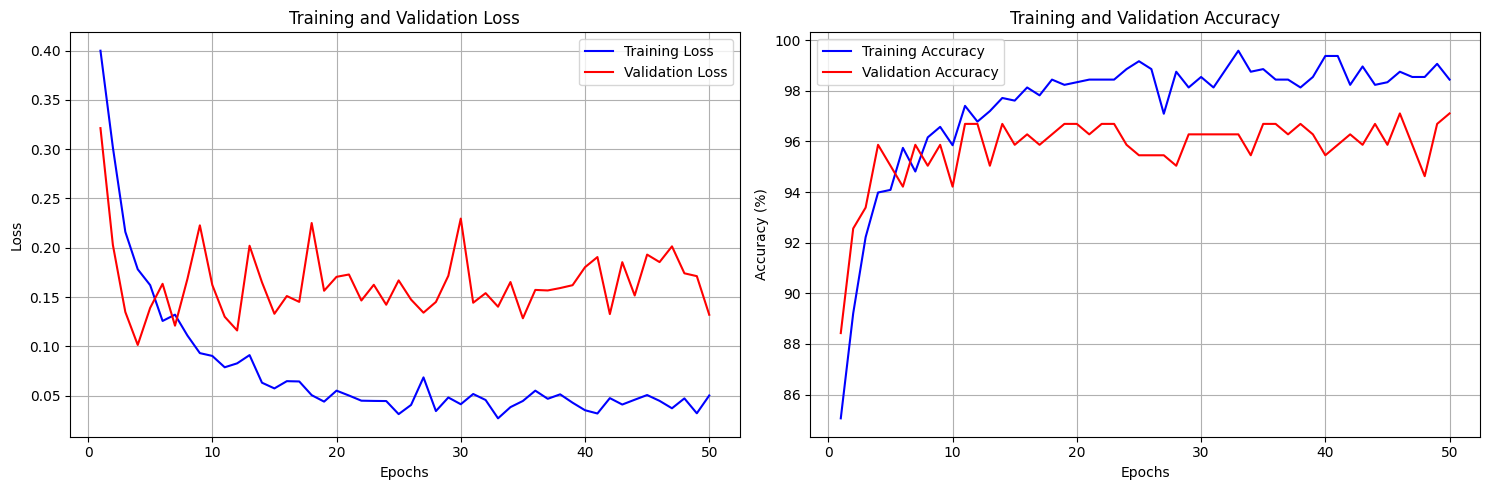

Training metrics plot saved as 'training_metrics.png'


In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

Save model

In [ ]:
def Save_Model():
    torch.save(model_pretrained.state_dict(), '/content/drive/MyDrive/model_pretrained.pth')
    print("Model saved successfully!")
    return

def Load_Model():
    model_pretrained.load_state_dict(torch.load('/content/drive/MyDrive/model_simplecnn_2.pth'))
    model_pretrained.eval()
    print("Model loaded successfully!")
    return

In [ ]:
Save_Model()

Model saved successfully!


Output predicted test data

In [ ]:
import os
# === Set paths ===
test_folder_path = "/content/drive/MyDrive/dataset_beam/test"
model_path = "/content/drive/MyDrive/model_simplecnn_2.pth"
output_csv_path = "/content/drive/MyDrive/submission.csv"
file_extension = ".jpg"
idx_to_class = {0: "A", 1: "B", 2: "C"}


# === Load model ===
model_pretrained.to(device)
model_pretrained.eval()

# === Define image transform (same as training) ===
mean, std = compute_mean_std('/content/drive/MyDrive/dataset_beam/beam_damage')
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

# === Prepare output storage ===
predictions = []

# === Loop through test images ===
def count_images_in_dir(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    return sum(1 for file in os.listdir(directory) if file.lower().endswith(image_extensions))

# Example usage
image_dir = '/content/drive/MyDrive/dataset_beam/test'
num_images = count_images_in_dir(image_dir)
print(f"Number of images in folder: {num_images}")

for img_id in tqdm(range(1, num_images+1)):
    img_name = f"{img_id}{file_extension}"
    img_path = os.path.join(test_folder_path, img_name)

    try:
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model_pretrained(img_tensor)
            _, predicted = torch.max(output.data, 1)
            label = predicted.item()

        predictions.append((img_id, idx_to_class[label]))

    except Exception as e:
        print(f"❗ Error with image {img_name}: {e}")
        predictions.append((img_id, "error"))

# === Save to CSV ===
predictions.sort(key=lambda x: x[0])
df = pd.DataFrame(predictions, columns=["id", "class"])
df.to_csv("predictions.csv", index=False)

print("✅ Done! Predictions saved to predictions.csv")

Found 402 images.


Computing mean & std: 100%|██████████| 402/402 [00:02<00:00, 144.41it/s]


Number of images in folder: 100


100%|██████████| 100/100 [00:01<00:00, 65.53it/s]

✅ Done! Predictions saved to predictions.csv
